# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.735058,True,5.492055
1,2.373844,True,7.434484
2,0.109087,True,4.395485
3,0.385280,True,5.918364
4,0.342354,False,1.671708
...,...,...,...
995,0.721946,True,7.802852
996,-1.278261,True,2.438687
997,0.739223,False,1.177654
998,1.605937,True,6.771141


<Axes: xlabel='v0'>

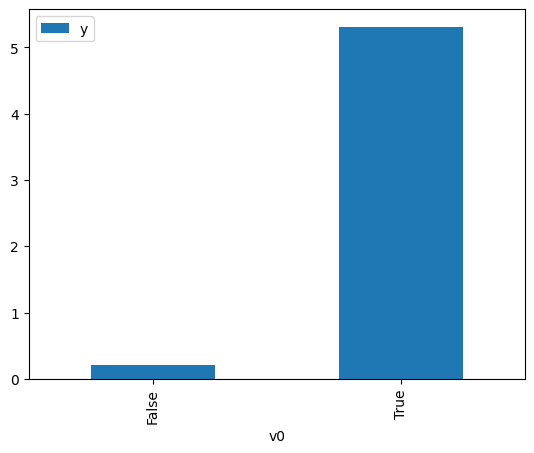

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

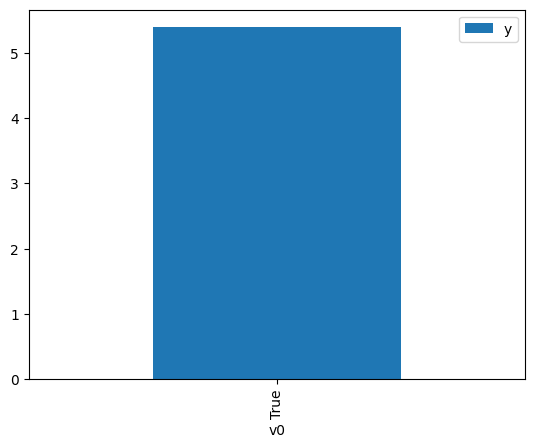

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.648197,False,3.311792,0.236542,4.227575
1,1.244481,False,2.131991,0.369171,2.708769
2,1.249983,False,3.904493,0.368591,2.713034
3,0.761553,False,0.933221,0.421412,2.372977
4,0.848728,False,2.251458,0.411813,2.428288
...,...,...,...,...,...
995,-0.004935,False,-0.386961,0.507569,1.970176
996,1.001667,False,-0.262225,0.395138,2.530762
997,1.035101,False,0.824463,0.391523,2.554126
998,-0.101056,False,-1.706805,0.518448,1.928833


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.510788,True,9.088516,0.658457,1.518703
1,1.688209,True,7.435233,0.676297,1.478640
2,-0.115654,True,4.651242,0.479901,2.083763
3,-0.381311,True,4.476510,0.449969,2.222376
4,-0.866224,True,4.082236,0.396400,2.522704
...,...,...,...,...,...
995,-2.308917,True,0.496417,0.254623,3.927368
996,-0.717743,True,3.385428,0.412602,2.423641
997,0.144009,True,5.435488,0.509299,1.963482
998,1.064319,True,6.265042,0.611626,1.634987


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9993.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:11:24   Log-Likelihood:                         -1405.0
No. Observations:                1000   AIC:                                      2814.
Df Residuals:                     998   BIC:                                      2824.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7460      0.032     54.469      0.000       1.683       1.809
x2             4.9821      0.045    109.763      0.000       4.893       5.071
==============================================================================
Omnibus:                        1.486   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                1.544
Skew:                          -0.090   Prob(JB):                        0.462
Kurtosis:                       2.934   Cond. No.                         1.58
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""